- Calculate the mean landfill emissions
- Plot scatters on map
- Add plume cases to map figure

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib
from ast import literal_eval
from matplotlib import text as mtext
import matplotlib.patches as patches
import contextily as cx
import geopandas as gpd
import matplotlib.lines as mlines

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
# rcParams['axes.labelsize'] = font_size - 2
# rcParams['xtick.labelsize'] = font_size - 2
# rcParams['ytick.labelsize'] = font_size - 2
# rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Plotting functions

In [3]:
class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, text_color, axes, **kwargs):
        super(CurvedText, self).__init__(x[0],y[0],' ', **kwargs)

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == ' ':
                ##make this an invisible 'a':
                t = mtext.Text(0,0,'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0,0,c,
                               fontproperties={'size': 15, 'weight': 'bold'},
                               color=text_color,
                               **kwargs)

            #resetting unnecessary arguments
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder +1)

            self.__Characters.append((c,t))
            axes.add_artist(t)


    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)

    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """

        #preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357

        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        aspect = ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])

        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )

        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)

        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)

        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)


        rel_pos = 10
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue

            elif c != ' ':
                t.set_alpha(1.0)

            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]

            #if we exactly hit a data point:
            if ir == il:
                ir += 1

            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
            rel_pos = l_fig[il]

            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
            y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])

            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)

            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])

            #the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array([
                [np.cos(rad), np.sin(rad)*aspect],
                [-np.sin(rad)/aspect, np.cos(rad)]
            ])

            ##computing the offset vector of the rotated character
            drp = np.dot(dr,rot_mat)

            #setting final position and rotation:
            t.set_position(np.array([x,y])+drp)
            t.set_rotation(degs[il])

            t.set_va('center')
            t.set_ha('center')

            #updating rel_pos to right edge of character
            rel_pos += w-used

In [4]:
def plot_plume_circle(filename, ax, zoom=1):
    ds = xr.open_dataset(filename)
    df = pd.read_csv(filename.replace('.nc', '.csv'), converters={'plume_bounds': literal_eval})
    proj = ccrs.PlateCarree()

    # calculate the pad around source center
    lon_min, lat_min, lon_max, lat_max = df['plume_bounds'].item()
    lon_width = lon_max - lon_min
    lat_width = lat_max - lat_min
    pad = max(lon_width, lat_width)*1.25/zoom

    # set extent
    lon_min = df['plume_longitude'] - pad*1.2
    lon_max = df['plume_longitude'] + pad*1.2
    lat_min = df['plume_latitude'] - pad*1.3
    lat_max = df['plume_latitude'] + pad*1.4

    extent = (lon_min.item(), lon_max.item(), lat_min.item(), lat_max.item())
    ax.set_extent(extent, crs=proj)

    cx.add_basemap(ax, crs=proj, source=cx.providers.Esri.WorldImagery)
    # remove watermark
    ax.texts[0].remove()

    # get the background as image array
    for child in ax.get_children():
        if isinstance(child, matplotlib.image.AxesImage):
            print(f"* Found image object. {child}")
            child0 = child
            ccmap = child0.get_cmap()
            img_array = child0.get_array()
            break
        pass

    # clear the axis
    plt.cla()

    # create patch
    center = [df['plume_longitude'].item(), df['plume_latitude'].item()]
    patch = patches.Circle((center[0], center[1]), radius=pad, transform=ax.transData)

    # clip the image
    osm_img = ax.imshow(img_array, extent=extent, origin='lower', cmap=ccmap)
    osm_img.set_clip_path(patch)

    # plot rgb and ch4 data
    m = ds['ch4'].plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=600, cmap='plasma', add_colorbar=False, rasterized=True)
    m.set_clip_path(patch)

    # plot filled circle for inside titles
    radii = [pad*0.8, pad]
    theta = np.linspace(0, 2*np.pi, 50, endpoint=True)
    xs = np.outer(radii, np.cos(theta)) + center[0]
    ys = np.outer(radii, np.sin(theta)) + center[1]

    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    ax.fill(np.ravel(xs), np.ravel(ys), facecolor='gray', alpha=0.6)

    ax.set_title('')

    top_title = df['datetime'].item().split('T')[0] + '  ' \
            + str(round(df['emission'].item()/1e3, 1)) + ' ± ' + str(round(df['emission_uncertainty'].item()/1e3, 1)) + ' t/h'
    
    bottom_title = df['name'].item()+', '+df['country'].item()
    instrument_title = df['platform'].item()

    # hard-code for position
    top_curve = [-np.cos(np.linspace(np.pi/6, np.pi, 100))*pad*0.95+center[0],
                np.sin(np.linspace(np.pi/6, np.pi, 100))*pad*0.95+center[1]]

    bottom_curve = [-np.cos(np.linspace(-np.pi/4.9, -np.pi, 100))*pad*1.1+center[0],
                np.sin(np.linspace(-np.pi/4.9, -np.pi, 100))*pad*1.1+center[1]]

    instrument_curve = [-np.cos(np.linspace(-np.pi/2.5, -np.pi, 100))*pad*0.95+center[0],
                np.sin(np.linspace(-np.pi/2.5, -np.pi, 100))*pad*0.95+center[1]]

    # ax.plot(*top_curve, color='b')
    # ax.plot(*bottom_curve, color='r')

    top_text = CurvedText(
                x = top_curve[0],
                y = top_curve[1],
                text=top_title,
                va = 'top',
                text_color='w',
                axes = ax, ##calls ax.add_artist in __init__
            )

    instrument_text = CurvedText(
                x = instrument_curve[0],
                y = instrument_curve[1],
                text=instrument_title,
                va = 'bottom',
                text_color='w',
                axes = ax, ##calls ax.add_artist in __init__
            )

    bottom_text = CurvedText(
                x = bottom_curve[0],
                y = bottom_curve[1],
                text=bottom_title,
                va = 'top',
                text_color=plt.cm.Greys(.75),
                axes = ax, ##calls ax.add_artist in __init__
            )

    ax.set_extent(extent, crs=proj)

    return center[0], center[1], m


In [5]:
def plot_line_circle(fig, ax_map, ax2, lon, lat):
    """Plot connecting line between axes"""
    transFigure = fig.transFigure.inverted()

    coord1 = transFigure.transform(ax2.transAxes.transform((0.5, 0.5)))

    x_map, y_map = ax_map.projection.transform_point(lon, lat, ccrs.PlateCarree())
    coord2 = transFigure.transform(ax_map.transData.transform([x_map, y_map]))

    line = plt.Line2D((coord1[0], coord2[0]), (coord1[1], coord2[1]), transform=fig.transFigure, zorder=1)
    fig.lines.append(line)

In [6]:
df_summary = pd.read_csv('../data/landfills_hyper_summary.csv')

# read the OBS file
df_obs = pd.read_excel('../data/landfills_hyper_obs.xlsx')

# remove space at end
df_obs['name'] = df_obs['name'].str.strip()

# tropomi hotspots with no observations of HSI (only consider EnMAP and EMIT)
# no_obs_mask = (df['source_tropomi']==1) & (df[['overpass(emit)', 'overpass(enmap)', 'overpass(prisma)']].sum(axis=1) == 0)
no_obs_mask = (df_obs['source_tropomi']==1) & (df_obs[['overpass(emit)', 'overpass(enmap)']].sum(axis=1) == 0)
obs_mask = ~no_obs_mask

# tropomi hotspots with no plume detected by HSI
no_plume_mask = (df_obs['source_tropomi']==1) & (df_obs[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) == 0) & obs_mask

# plumes only detected by HSI 
hsi_plume_mask = (df_obs['source_tropomi']==0) & (df_obs[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) > 0) 

# tropomi hotspots with at least one plume detected by any HSI
both_plume_mask = (df_obs['source_tropomi']==1) & (df_obs[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) > 0)

# plume mask
plume_mask = df_obs[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) > 0

# hotspots mask
hotspots_mask = df_obs['source_tropomi'] == 1

/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_97302/571932133.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


* Found image object. AxesImage(shape=(969, 1077, 4))
* Found image object. AxesImage(shape=(1354, 1255, 4))
* Found image object. AxesImage(shape=(1435, 1161, 4))
* Found image object. AxesImage(shape=(714, 818, 4))


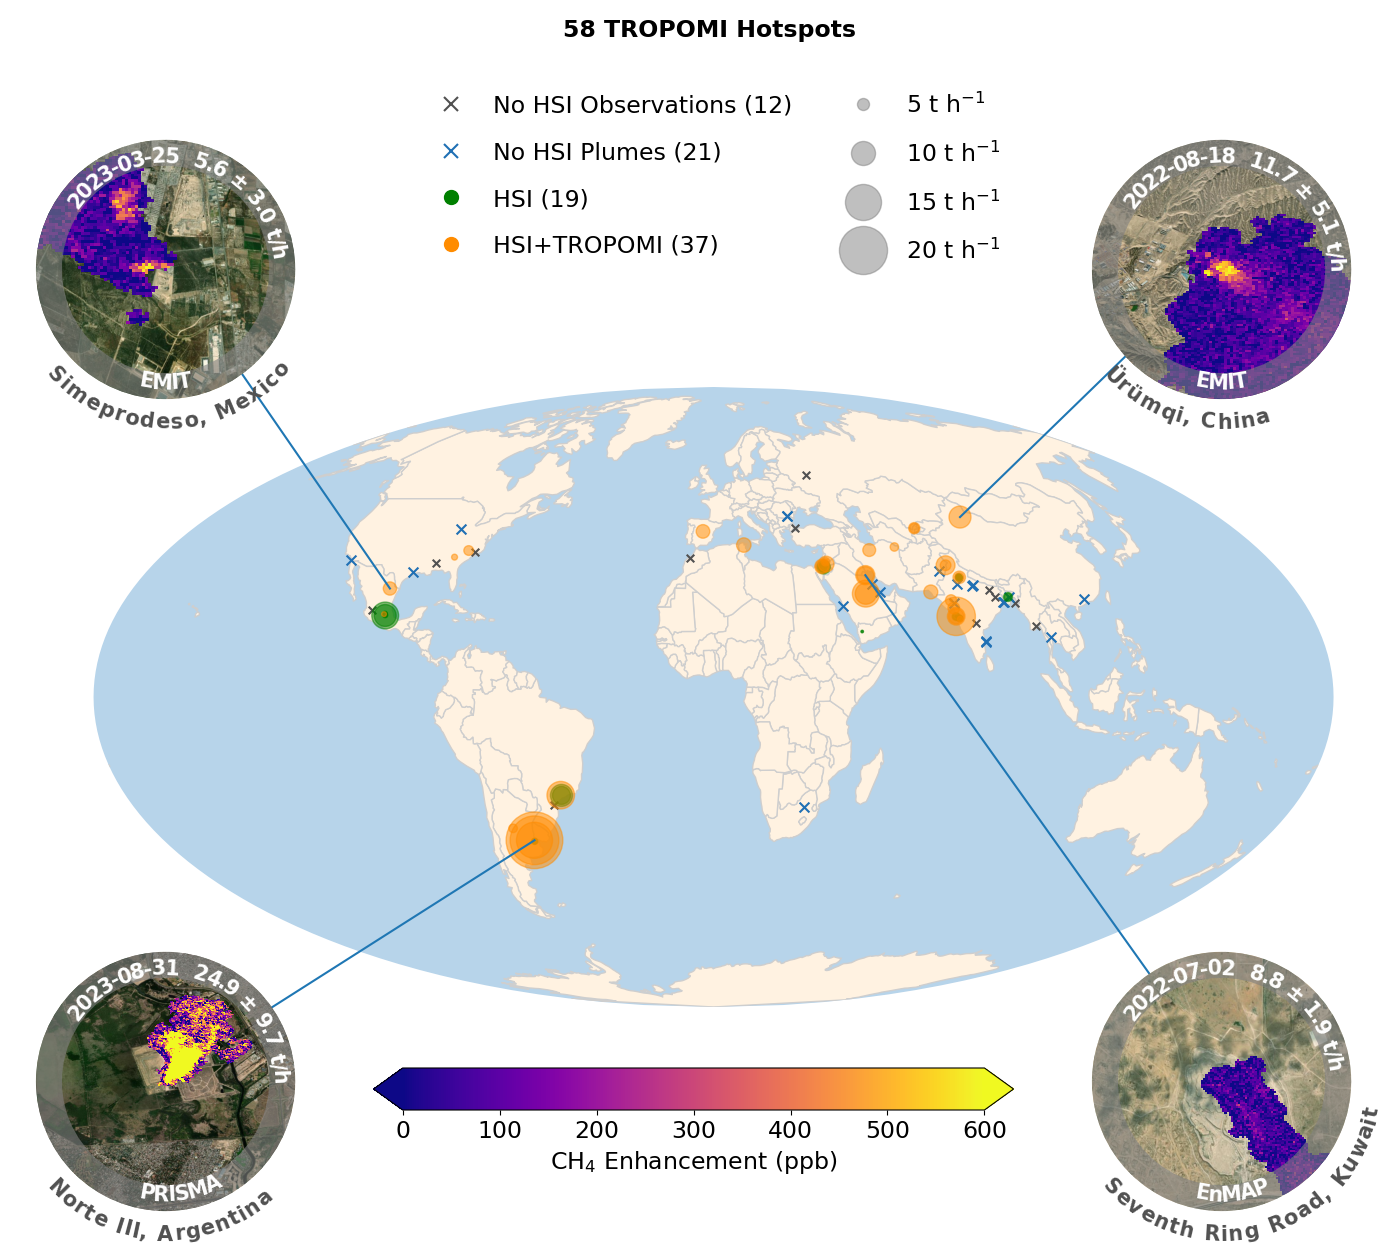

In [7]:
# Creating axes and plotting world map
crs = ccrs.Mollweide()

fig, ax_map = plt.subplots(figsize=(16, 14),
                    #    facecolor = plt.cm.Blues(.3),
                       subplot_kw={'projection':ccrs.Mollweide()},
                     #   constrained_layout=True,
                       )

# Getting world map data from geo pandas
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# convert to same proj
worldmap = worldmap.to_crs(crs.proj4_init)

worldmap.plot(color=plt.cm.OrRd(.04), ax=ax_map, edgecolor=plt.cm.Greys(.3))
ax_map.set_facecolor(plt.cm.Blues(.3))


# plot data
# --- no OBS --- #
no_obs_color = plt.cm.Greys(.75)
no_obs_cross = mlines.Line2D([], [], color=no_obs_color, marker='x', linestyle='None',
                             markersize=10, markeredgewidth=1.5, label=f'No HSI Observations ({len(df_obs[no_obs_mask])})'
                             )
df_obs[no_obs_mask].plot(ax=ax_map, x='longitude', y='latitude', kind='scatter', marker='x',
                      color=no_obs_color, s=30, linewidths=1.5, transform=ccrs.PlateCarree()
                      )

# --- No plume --- #
no_plume_color = plt.cm.Blues(.75)
no_plume_cross = mlines.Line2D([], [], color=no_plume_color, marker='x', linestyle='None',
                               markersize=10, markeredgewidth=1.5, label=f'No HSI Plumes ({len(df_obs[no_plume_mask])})'
                               )
df_obs[no_plume_mask].plot(ax=ax_map, x='longitude', y='latitude', kind='scatter', marker='x',
                       color=no_plume_color, s=50, linewidths=1.5, transform=ccrs.PlateCarree()
                       )

# --- HSI plume --- #
hsi_plume_color = 'green'
df_hsi_plume = df_obs[hsi_plume_mask][['name']].merge(df_summary, on='name', how='left')
hsi_scatter = ax_map.scatter(df_hsi_plume['longitude'], df_hsi_plume['latitude'], c=hsi_plume_color,
                         s=2*df_hsi_plume['emission']**2, alpha=0.5, transform=ccrs.PlateCarree()
                         )
hsi_plume_scatter = mlines.Line2D([], [], color=hsi_plume_color, marker='o',
                                  linestyle='None', markersize=10, label=f'HSI ({len(df_hsi_plume)})'
                                  )

# --- HSI+TROPOMI plume --- #
both_plume_color = 'darkorange'
df_both_plume = df_obs[both_plume_mask][['name']].merge(df_summary, on='name', how='left')
# both_scatter = ax.scatter(df_both_plume['longitude'], df_both_plume['latitude'], c=both_plume_color,
#                           s=2*df_both_plume['emission']**2, alpha=0.5, transform=ccrs.PlateCarree()
#                           )

both_plume_scatter = mlines.Line2D([], [], color=both_plume_color, marker='o', linestyle='None',
                                   markersize=10, label=f'HSI+TROPOMI ({len(df_both_plume)})'
                                   )

df_all_plume = pd.concat([df_hsi_plume, df_both_plume], ignore_index=True)
all_scatter = ax_map.scatter(df_all_plume['longitude'], df_all_plume['latitude'],
                         color=[hsi_plume_color]*len(df_hsi_plume) + [both_plume_color]*len(df_both_plume),
                         s=3*df_all_plume['emission']**2, alpha=0.5, transform=ccrs.PlateCarree()
                         )

# --- emission rate legend ---
kw = dict(prop="sizes", num=5,
          color='gray',
          fmt="{x:.0f} t h$^{{-1}}$",
          func=lambda s: np.sqrt(s/3),
          )

# create marker and label list
markers = [no_obs_cross, no_plume_cross, hsi_plume_scatter, both_plume_scatter]
labels = [m.get_label() for m in markers]

# add the emission rate marker to list
fake_empty_line = mlines.Line2D([], [], color="none")

markers.append(fake_empty_line)
labels.append(fake_empty_line.get_label())

# plot size
markers.extend(all_scatter.legend_elements(**kw)[0])
labels.extend(all_scatter.legend_elements(**kw)[1])

# add legend
legend = ax_map.legend(markers, labels,
                    loc="lower center",
                    fontsize=17,
                    ncol=2,
                    title=f"{len(df_obs[df_obs['source_tropomi']==1])} TROPOMI Hotspots \n",
                    title_fontproperties={'weight':'bold', 'size': 17},
                    bbox_to_anchor=(0.5, 1.1),
                    frameon=False,
                    labelspacing=1,
                    )

# ----------- plume cases ----------------
ax1 = fig.add_axes([0.07, 0.68, 0.2, 0.25],  # left, bottom, width, height
                   projection=ccrs.PlateCarree(),
                   )
f_Simeprodeso = '../data/Hyper_plume_cases/Simeprodeso/EMIT_L3B_001_20230325T212507_2308414_005_plume0.nc'
lon, lat, _ = plot_plume_circle(f_Simeprodeso, ax1, zoom=2)
plot_line_circle(fig, ax_map, ax1, lon, lat)

ax2 = fig.add_axes([0.73, 0.68, 0.2, 0.25],
                    projection=ccrs.PlateCarree(),
                   )
f_Ürümqi = '../data/Hyper_plume_cases/Ürümqi/EMIT_L3B_001_20220818T070105_2223005_022_plume0.nc'
lon, lat, _ = plot_plume_circle(f_Ürümqi, ax2, zoom=4)
plot_line_circle(fig, ax_map, ax2, lon, lat)

ax3 = fig.add_axes([0.07, 0.1, 0.2, 0.25],
                    projection=ccrs.PlateCarree(),
                   )

f_Norte_III = '../data/Hyper_plume_cases/Norte_III/PRS_L3_STD_OFFL_20230831140006_20230831140010_0001_plume0.nc'
lon, lat, _ = plot_plume_circle(f_Norte_III, ax3)
plot_line_circle(fig, ax_map, ax3, lon, lat)

ax4 = fig.add_axes([0.73, 0.1, 0.2, 0.25],
                    projection=ccrs.PlateCarree(),
                   )
f_Seventh_Ring_Road = '../data/Hyper_plume_cases/Seventh_Ring_Road/ENMAP01-____L3B-DT0000001450_20220702T080525Z_003_V010302_20230712T175800Z_plume0.nc'
lon, lat, m = plot_plume_circle(f_Seventh_Ring_Road, ax4, zoom=3)
plot_line_circle(fig, ax_map, ax4, lon, lat)

# add colorbar
cax = fig.add_axes([0.3, 0.2, 0.4, 0.03])
cb = fig.colorbar(m, cax=cax, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=17)
cb.ax.set_xlabel('CH$_4$ Enhancement (ppb)', fontsize=17)

# delete axis
for ax in [ax_map, ax1, ax2, ax3, ax4]:
   [spine.set_visible(False) for spine in ax.spines.values()]
   ax.xaxis.set_visible(False)
   ax.yaxis.set_visible(False)

# transparent background
for ax in [ax1, ax2, ax3, ax4]:
   ax.set_zorder(5)
   ax.patch.set_alpha(0)

# tight layout and remove background
fig.patch.set_facecolor('w')
fig.patch.set_alpha(0)

fig.savefig('../figures/emission_map.pdf')